In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
# set up matplotlib
is_ipython = "inline" in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()



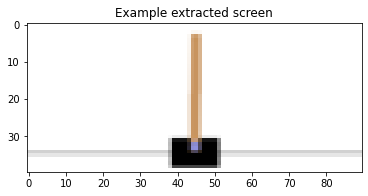

In [8]:
from reinforcement_learning_example.agent_cnn import get_screen
import gym
env = gym.make("CartPole-v1").unwrapped
try:
    env.reset()
    plt.figure()
    plt.imshow(get_screen(env=env).cpu().squeeze(0).permute(1, 2, 0).numpy(),
               interpolation=None)
    plt.title('Example extracted screen')
    plt.show()
finally:
    env.close()



In [4]:
import gym
import torch.optim as optim

from reinforcement_learning_example.agent_cnn import DQN, ReplayMemory
from reinforcement_learning_example.agent_cnn import get_screen

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

env = gym.make("CartPole-v1").unwrapped
env.reset()

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen(env=env)
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
num_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, num_actions)
target_net = DQN(screen_height, screen_width, num_actions)
device = policy_net.device

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [ ]:
steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(num_actions)]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        display.clear_output(wait=True)
        display.display(plt.gcf())